In [40]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
IMG_DIM = 28

In [41]:
mndata = MNIST('../mnist')
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

train_images, train_labels = np.array(train_images), np.array(train_labels)
test_images, test_labels = np.array(test_images), np.array(test_labels)

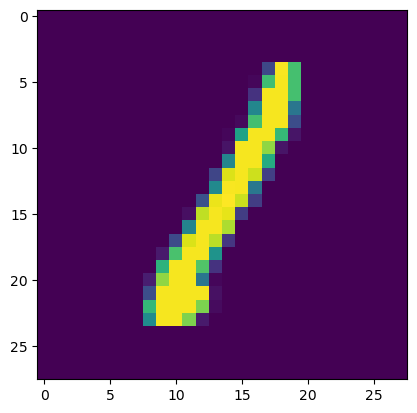

In [42]:
img_idx = np.random.randint(len(test_images))
plt.imshow(test_images[img_idx].reshape(IMG_DIM, IMG_DIM))
plt.show()


In [43]:
# Creating validation set and convert to tensors
from sklearn.model_selection import train_test_split 
import torch
train_images.shape, train_labels.shape
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.10)

n_train, n_val = train_images.shape[0], val_images.shape[0]
train_images = train_images.reshape(n_train, 1, IMG_DIM, IMG_DIM)
val_images = val_images.reshape(n_val, 1, IMG_DIM, IMG_DIM)
test_images = test_images.reshape(test_images.shape[0], 1, IMG_DIM, IMG_DIM)

train_images, val_images, test_images = torch.from_numpy(train_images).type(torch.FloatTensor), torch.from_numpy(val_images).type(torch.FloatTensor), torch.from_numpy(test_images).type(torch.FloatTensor)
train_labels, val_labels, test_labels = train_labels.astype(int), val_labels.astype(int), test_labels.astype(int)
train_labels, val_labels, test_labels = torch.from_numpy(train_labels), torch.from_numpy(val_labels), torch.from_numpy(test_labels) 


In [44]:
# Let's define some variables
DEVICE = torch.device("cude" if torch.cuda.is_available() else "cpu")
N_EPOCHS = 20
BATCH_SIZE = 150
LEARNING_RATE = 1e-2
DROP_OUT_RATE = 1e-1
N_CLASSES = (train_labels.max() + 1).item()

In [45]:
# Create CNN
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 13, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(13),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ) 
        self.fc1 = nn.Sequential(
            nn.Linear(13*5*5, 180),
            nn.Dropout(DROP_OUT_RATE),
            nn.Linear(180, 10),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [46]:
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from torch import optim
import time
model = CNN()
model.train()
criterion = nn.CrossEntropyLoss()   
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)


train = torch.utils.data.TensorDataset(train_images,train_labels)
val = torch.utils.data.TensorDataset(val_images, val_labels)
test = torch.utils.data.TensorDataset(test_images, test_labels)

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

def train(train_loader, val_loader, test_loader):
    writer = SummaryWriter()
    train_accuaracy, train_loss = evaluate(train_loader)
    val_accuaracy, val_loss = evaluate(val_loader)
    
    writer.add_scalar("Accuaracy/train", train_accuaracy, 0)
    writer.add_scalar("Accuaracy/val", val_accuaracy, 0)
    writer.add_scalar("Loss/train", train_loss, 0)
    writer.add_scalar("Loss/val", val_loss, 0)
    tic = time.perf_counter()
    toc = time.perf_counter()
    time_format = time.strftime("%M:%S", time.gmtime(toc - tic))
    print(f"Time elapsed: {time_format}, epoch: {str(0).zfill(2)}/{N_EPOCHS}, train loss: {train_loss:.2f}, train accuaracy: {train_accuaracy:.2f}, val loss: {val_loss:.2f}, val accuaracy: {val_accuaracy:.2f}")

    for epoch in range(1, N_EPOCHS+1):
        
        correctly_classified = 0
        total_classified = 0
        train_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            train = Variable(images)
            labels = Variable(labels)
            optimizer.zero_grad()
        
            out = model(train)
            loss = criterion(out, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.max(out.data, 1)[1]
            total_classified += len(labels)
            correctly_classified += (predicted == labels).sum().item()
        
        val_accuaracy, val_loss = evaluate(val_loader)
        train_accuaracy = 100 * correctly_classified / total_classified  
        writer.add_scalar("Accuaracy/train", train_accuaracy, epoch)
        writer.add_scalar("Accuaracy/val", val_accuaracy, epoch)
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)
        toc = time.perf_counter()
        time_format = time.strftime("%M:%S", time.gmtime(toc - tic))
        print(f"Time elapsed: {time_format}, epoch: {str(epoch).zfill(2)}/{N_EPOCHS}, train loss: {train_loss:.2f}, train accuaracy: {train_accuaracy:.2f}, val loss: {val_loss:.2f}, val accuaracy: {val_accuaracy:.2f}")
    writer.flush()

def evaluate(data_loader):
    
    with torch.no_grad():
        correctly_classified = 0
        total_classified = 0
        loss = 0
        for i, (images, labels) in enumerate(data_loader):
            
            train, labels = Variable(images), Variable(labels)
            out = model(train)
            loss = criterion(out, labels)
            loss += loss.item()
            predicted = torch.max(out.data, 1)[1]
            total_classified += len(labels)
            correctly_classified += (predicted == labels).sum().item()

    accuaracy = 100 * correctly_classified / total_classified
    return accuaracy, loss

In [47]:
train(train_loader, val_loader, test_loader)

Time elapsed: 00:00, epoch: 00/20, train loss: 4.78, train accuaracy: 12.65, val loss: 4.78, val accuaracy: 12.73
Time elapsed: 00:26, epoch: 01/20, train loss: 72.53, train accuaracy: 94.18, val loss: 0.10, val accuaracy: 98.02
Time elapsed: 00:54, epoch: 02/20, train loss: 21.32, train accuaracy: 98.20, val loss: 0.04, val accuaracy: 98.42
Time elapsed: 01:26, epoch: 03/20, train loss: 17.59, train accuaracy: 98.50, val loss: 0.17, val accuaracy: 98.58
Time elapsed: 01:51, epoch: 04/20, train loss: 15.22, train accuaracy: 98.69, val loss: 0.03, val accuaracy: 98.50
Time elapsed: 02:16, epoch: 05/20, train loss: 14.34, train accuaracy: 98.72, val loss: 0.04, val accuaracy: 98.15
Time elapsed: 02:42, epoch: 06/20, train loss: 12.49, train accuaracy: 98.86, val loss: 0.24, val accuaracy: 98.55
Time elapsed: 03:11, epoch: 07/20, train loss: 13.49, train accuaracy: 98.86, val loss: 0.16, val accuaracy: 98.52
Time elapsed: 03:37, epoch: 08/20, train loss: 13.39, train accuaracy: 98.84, val

In [48]:
test_accuaracy, _ = evaluate(test_loader)
print(f"Final test evaluation score: {test_accuaracy:.2f}")

Final test evaluation score: 98.72
